# Example notebook for XAI algorithms quantitive evaluation

This tutorial is based on [Quantus notebook](https://github.com/understandable-machine-intelligence-lab/Quantus/blob/main/tutorials/Tutorial_ImageNet_Quantification_with_Quantus.ipynb) with guideline how to get started using [Quantus](https://github.com/understandable-machine-intelligence-lab/Quantus) library.

In this tutorial, You will see how You can use explainable algorithms to study pre-trained model decision and quantify those algorithms using metrics provided by Quantus library. We will take a pre-trained model, sample images, run several explainable methods and quantify them for further analysis.

### Setup 

Install missing libraries.

In [1]:
!pip install opencv-python seaborn quantus cachetools


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


#### Imports

First we have to import all necessary libraries.

In [2]:
# import necessary libraries
import os
import torch
from torch.utils.data import DataLoader
import torchvision

from foxai.context_manager import FoXaiExplainer, ExplainerWithParams, CVClassificationExplainers
from foxai.visualizer import mean_channels_visualization

import quantus
import numpy as np
from foxai.explainer.computer_vision.algorithm.integrated_gradients import IntegratedGradientsCVExplainer
from foxai.explainer.computer_vision.algorithm.input_x_gradient import InputXGradientCVExplainer
from foxai.explainer.computer_vision.algorithm.gradient_shap import GradientSHAPCVExplainer
from foxai.explainer.computer_vision.algorithm.guided_backprop import GuidedBackpropCVExplainer
from foxai.explainer.computer_vision.algorithm.gradcam import LayerGradCAMCVExplainer
from foxai.explainer.computer_vision.algorithm.gradcam import GuidedGradCAMCVExplainer
from functools import partial

import cv2
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.transforms._presets import ImageClassification
from typing import Tuple, List, Dict, Callable, Optional
import seaborn as sns
import pandas as pd
from time import time

# Plotting specifics.
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configure `CUDA_LAUNCH_BLOCKING=1` to prevent issues with `CUDA` while running GPU-accelerated computations in notebook.

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#### Define custom functions

Define function that will load model, list of labels and transformation function of a desired model. Currently we support, in this notebook, only a few models: `VGG11`, `ResNet50`, `ViT`, `MobileNetV3` and `YOLOv5`. You can easilly add new models from `torchvision` model zoo and even define Your own model.

In [4]:
def load_model(
    model_name: str,
) -> Tuple[torch.nn.Module, List[str], ImageClassification]:
    """Load model, label list and transformation function used in data preprocessing.

    Args:
        model_name: Model name. Recognized models are: `vgg11`, `resent50`, `vit` and
            `mobilenetv3`.

    Raises:
        ValueError: raised if provided model name that is not supported.

    Returns:
        Tuple of model, list of labels and transformation function.
    """
    # normalize model name to match recognized models
    model_name_normalized: str = model_name.lower().strip()
    if model_name_normalized == "vgg11":
        weights = torchvision.models.VGG11_Weights.IMAGENET1K_V1

        # load model from torchvision model zoo
        model = torchvision.models.vgg11(weights=weights)

        # get class names
        categories = weights.meta["categories"]
        transform = weights.transforms()
    elif model_name_normalized == "vit":
        weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1

        # load model from torchvision model zoo
        model = torchvision.models.vit_b_16(weights=weights)

        # get class names
        categories = weights.meta["categories"]
        transform = weights.transforms()
    elif model_name_normalized == "resnet50":
        weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1

        # load model from torchvision model zoo
        model = torchvision.models.resnet50(weights=weights)

        # get class names
        categories = weights.meta["categories"]
        transform = weights.transforms()
    elif model_name_normalized == "mobilenetv3":
        weights = torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1

        # load model from torchvision model zoo
        model = torchvision.models.mobilenet_v3_small(weights=weights)

        # get class names
        categories = weights.meta["categories"]
        transform = weights.transforms()
    else:
        raise ValueError(f"Unrecognized model name: {model_name}")

    return model, categories, transform

### Configuration

Cell below contains configuration of this notebook. We have defined max number of samples to be saved in artifact directory, path to `ImageNet-Mini` dataset downloaded from [Kaggle](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000), name of the model, batch_size and device to be used.

In [5]:
batch_size: int = 2
max_samples_explained: int = 10
device = torch.device("cpu")
model_name: str = "mobilenetv3"

# define directory where explanation artifacts will be stored
artifact_dir: str = f"artifacts/{model_name}/"
data_dir: str = "./MNIST"

### Loading the model

Load specified model, put it in evaluation mode, place it on specified device, download and preprocess `ImageNet-Mini` dataset. Trasformation function is used to match training dataset preprocessing steps.

In [6]:
# load model, classes and transformation function
model, categories, transform = load_model(model_name=model_name)

# put model in evaluation mode
model.eval()

# place model on specified device (CPU or GPU)
model.to(device)

# get last layer to explain
layer = [module for module in model.modules() if isinstance(module, torch.nn.Conv2d)][-1]

mnist_dataset = torchvision.datasets.MNIST(root=data_dir, download=True, transform=transforms.Compose([
    transforms.Grayscale(3),
    transforms.ToTensor(),
]))
val_dataloader = DataLoader(mnist_dataset, batch_size=batch_size)

In [7]:
# instruct notebook to display figures inline
%matplotlib inline

In [8]:
# Source code: https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html.

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default."""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default."""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, angles=None):
            self.set_thetagrids(angles=np.degrees(theta), labels=labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped."""
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)

                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


# Plotting configs.
sns.set(font_scale=1.8)
plt.style.use('seaborn-white')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True

def plot_spyder_graph(
    df_normalised_rank: pd.DataFrame,
    xai_methods: List[str],
    metric_weight_dict: Dict[str, float],
    include_titles: bool = True,
    include_legend: bool = True,
) -> None:
    # Make spyder graph!
    data = [df_normalised_rank.columns.values, (df_normalised_rank.to_numpy())]
    theta = radar_factory(len(data[0]), frame='polygon')
    _ = data.pop(0)

    fig, ax = plt.subplots(figsize=(11, 11), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(top=0.85, bottom=0.05)
    for d, method in zip(data[0], xai_methods):
        _ = ax.plot(
            theta,
            d,
            label=method,
            linewidth=5.0
        )
        ax.fill(theta, d, alpha=0.15)

    # Set lables.
    if include_titles:
        ax.set_varlabels(labels=list(metric_weight_dict.keys()))
    else:
        ax.set_varlabels(labels=[]) 

    # Set a title.
    ax.set_title("Summary of Explainer Quantification",  position=(0.5, 1.1), ha='center', fontsize=15)

    # Put a legend to the right of the current axis.
    if include_legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_52417/2231396749.py:92: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [9]:
def foxai_explainer_wrapper(
    explainer, model, inputs, targets, *args, **kwargs
) -> np.array:
    """Wrapper aorund captum's Saliency implementation."""
    torch.cuda.empty_cache()

    # Set model in evaluate mode.
    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = torch.as_tensor(inputs)

    if not isinstance(targets, torch.Tensor):
        targets = (
            torch.as_tensor(targets).long()
        )  # inputs = inputs.reshape(-1, 3, 224, 224)

    assert (
        len(np.shape(inputs)) == 4
    ), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."

    explanation = (
        explainer()
        .calculate_features(model, inputs, targets)
        .sum(axis=1)
        .detach()
        .cpu()
        .numpy()
    )

    torch.cuda.empty_cache()

    if not kwargs.get("normalise", None):
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.detach().cpu().detach().numpy()
        return explanation.detach().cpu().numpy()

    return explanation

integrated_gradients_explainer = partial(foxai_explainer_wrapper, explainer=IntegratedGradientsCVExplainer)
input_x_gradients_explainer = partial(foxai_explainer_wrapper, explainer=InputXGradientCVExplainer)
guided_backprop_explainer = partial(foxai_explainer_wrapper, explainer=GuidedBackpropCVExplainer)
layer_gradcam_explainer = partial(foxai_explainer_wrapper, explainer=LayerGradCAMCVExplainer)

explainer_wrapper = {
    "IntegratedGradients": integrated_gradients_explainer,
    "InputXGradient": input_x_gradients_explainer,
    "GuidedBackpropagation": guided_backprop_explainer,
    "LayerGradCAM": layer_gradcam_explainer,
}

In [131]:
def get_batch_data(
    dataloader: DataLoader,
    device: torch.device,
    max_batch_no: int,
) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
    """Get list of batches of data sample and labels.

    Args:
        dataloader: Dataloader to iterate.
        device: torch.Device to place batches to.
        max_batch_no: Number of batches.

    Returns:
        Tuple of lists of batches of data sample and labels.
    """
    x_batch_list: List[torch.Tensor] = []
    y_batch_list: List[torch.Tensor] = []
    for index, batch in enumerate(dataloader):
        sample_batch, label_batch = batch
        sample_batch.to(device)
        label_batch.to(device)

        x_batch_list.append(sample_batch)
        y_batch_list.append(label_batch)

        if index > max_batch_no:
            break

    return x_batch_list, y_batch_list

def compute_metrics_for_explainers(
    x_batch_list: List[torch.Tensor],
    y_batch_list: List[torch.Tensor],
    explainer_wrapper: Dict[str, Callable],
    model: torch.nn.Module,
    layer: torch.nn.Module,
    device: torch.device,
) -> Dict[str, Dict[str, List[np.ndarray]]]:
    explainer_attributes: Dict[str, Dict[str, List[np.ndarray]]] = {key: [] for key in explainer_wrapper.keys()}
    for sample_batch, label_batch in zip(x_batch_list, y_batch_list):
        for explainer_name, explainer in explainer_wrapper.items():
            start = time()
            
            attributes = explainer(
                model=model,
                inputs=sample_batch,
                targets=label_batch,
                **{
                    "device": device,
                    "layer": layer,    
                },
            )
            explainer_attributes[explainer_name].append(attributes)

            stop = time()
            print(f"Explainer name: {explainer_name}, time: {round(stop - start, 2)} seconds")


    for explainer_key in explainer_attributes.keys():
        explainer_attributes[explainer_key] = np.vstack(explainer_attributes[explainer_key])

    return explainer_attributes

x_batch_list, y_batch_list = get_batch_data(
    dataloader=val_dataloader,
    device=device,
    max_batch_no=20,
)
x_batch = np.vstack(x_batch_list)
y_batch = np.hstack(y_batch_list)
explainer_attributes = compute_metrics_for_explainers(
    x_batch_list=x_batch_list,
    y_batch_list=y_batch_list,
    explainer_wrapper=explainer_wrapper,
    model=model,
    layer=layer,
    device=device,
)

/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the d

Explainer name: InputXGradient, time: 0.02 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.02 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the d

Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.02 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

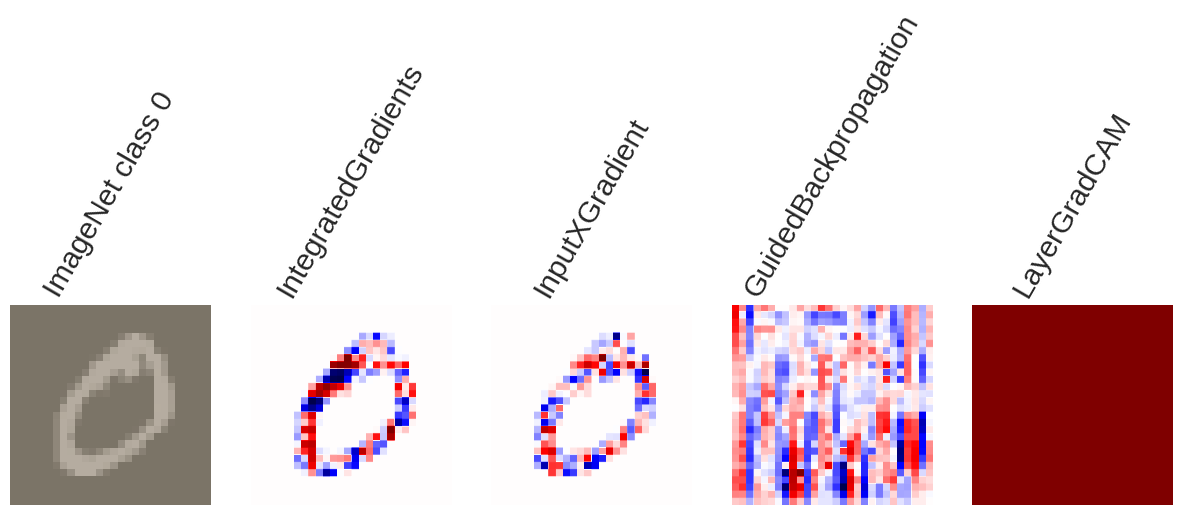

In [11]:
def visualize_attributes(
    index: int,
    explanations: Dict[str, List[np.ndarray]],
    max_height: int = 224,
    max_width: int = 224,
) -> None:
    """Visualize attributes from set of explainers in one plot.

    Args:
        index: Index of sample to visualize.
        explanations: Dictionary of attributes.
        max_height: Maximum height of image. Defaults to 224.
        max_width: Maximum width of image. Defaults to 224.
    """
    _, axes = plt.subplots(nrows=1, ncols=1+len(explanations), figsize=(15, 8))
    axes[0].imshow(
        np.moveaxis(
            quantus.normalise_func.denormalise(
                x_batch[index],
                mean=np.array([0.485, 0.456, 0.406]),
                std=np.array([0.229, 0.224, 0.225])
            ),
            0,
            -1
        ),
        vmin=0.0,
        vmax=1.0
    )
    axes[0].set_title(f"ImageNet class {y_batch[index].item()}", rotation=60)
    axes[0].axis("off")
    for i, (k, v) in enumerate(explanations.items()):
        if explanations[k][index].shape[0] < max_height:
            image = cv2.resize(explanations[k][index], None, fx=max_width, fy=max_height, interpolation=cv2.INTER_NEAREST)
        else:
            image = explanations[k][index]
        axes[i+1].imshow(
            quantus.normalise_func.normalise_by_negative(image),
            cmap="seismic",
            vmin=-1.0,
            vmax=1.0
        )
        axes[i+1].set_title(f"{k}", rotation=60)
        axes[i+1].axis("off")


visualize_attributes(index=1, explanations=explainer_attributes)

## Metrics

In the cell below we will define metrics that will be used for quantifying explainable algorithms. Those metrics, according to authors of Quantus library, are sensitive to different configurations and need to be carefully parametrized. To better understand how those parameters influence metric consider reading original papers describing metrics and study implementation code of Quantus library.

Library itself provides guidance about different parameters that may influence results in logs. It also provides original publication details.

In [12]:
# Define XAI methods and metrics.
xai_methods = list(explainer_attributes.keys())
metrics = {
    "EffectiveComplexity": quantus.EffectiveComplexity(
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=False,
    ),
    "EffectiveComplexityNormalised": quantus.EffectiveComplexity(
        abs=True,
        normalise=True,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=False,
    ),
    "Sparseness": quantus.Sparseness(
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=False,
    ),
    "SparsenessNormalised": quantus.Sparseness(
        abs=True,
        normalise=True,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=False,
    ),
    "Complexity": quantus.Complexity(
        abs=True,
        normalise=False,
    ),
    "ComplexityNormalised": quantus.Complexity(
        abs=True,
        normalise=True,
    ),
}

Warnings and information:
 (1) The Effective Complexity metric is likely to be sensitive to the choice of normalising 'normalise' (and 'normalise_func') and if taking absolute values of attributions 'abs' and the choice of threshold 'eps'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Nguyen, An-phi, and María Rodríguez Martínez. 'On quantitative aspects of model interpretability.' arXiv preprint arXiv:2007.07584 (2020)..
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.

Warnings and information:
 (1) The Effective Complexity metric is likely to be sensitive to the choice of normalising 'normalise' (and 'normalise_func') and if taking 

In [13]:
def compute_metrics(
    xai_methods: Dict[str, Callable],
    x_batch: torch.Tensor,
    y_batch: torch.Tensor,
    explainer_attributes: Dict[str, List[np.ndarray]],
    metrics: Dict[str, Callable],
) -> Dict[str, Dict[str, List[np.ndarray]]]:
    """Calculate metric score for each explainer.

    Args:
        xai_methods: Dictionary of explainer name and function.
        x_batch: Image batch tensor.
        y_batch: Label batch tensor.
        explainer_attributes: Dictionary of attributes for each explainer.
        metrics: Dictionary of metric name and function.

    Returns:
        Dictionary with name of metric and score for each explainer algorithm.
    """
    # run quantification analysis
    results = {method : {} for method in xai_methods}

    if isinstance(x_batch, torch.Tensor):
        x_batch = x_batch.detach().cpu().numpy()
    if isinstance(y_batch, torch.Tensor):
        y_batch = y_batch.detach().cpu().numpy()

    for method in explainer_attributes.keys():
        for metric, metric_func in metrics.items():
            start = time()
            torch.cuda.empty_cache()

            # Get scores and append results.
            scores = metric_func(
                model=model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=explainer_attributes[method],
                s_batch=None,
                device=device,
                explain_func=explainer_wrapper[method],
                explain_func_kwargs={
                    "device": device,
                },
            )
            results[method][metric] = scores
            stop = time()
            print(f"Evaluating {metric} of {method} method, time: {round(stop - start, 2)} seconds")

            # Empty cache.
            torch.cuda.empty_cache()

    return results

results = compute_metrics(
    xai_methods=xai_methods,
    x_batch=x_batch,
    y_batch=y_batch,
    explainer_attributes=explainer_attributes,
    metrics=metrics,
)

Evaluating EffectiveComplexity of IntegratedGradients method, time: 0.0 seconds
Evaluating EffectiveComplexityNormalised of IntegratedGradients method, time: 0.0 seconds
Evaluating Sparseness of IntegratedGradients method, time: 0.0 seconds
Evaluating SparsenessNormalised of IntegratedGradients method, time: 0.0 seconds
Evaluating Complexity of IntegratedGradients method, time: 0.0 seconds
Evaluating ComplexityNormalised of IntegratedGradients method, time: 0.0 seconds
Evaluating EffectiveComplexity of InputXGradient method, time: 0.0 seconds
Evaluating EffectiveComplexityNormalised of InputXGradient method, time: 0.0 seconds
Evaluating Sparseness of InputXGradient method, time: 0.0 seconds
Evaluating SparsenessNormalised of InputXGradient method, time: 0.0 seconds
Evaluating Complexity of InputXGradient method, time: 0.0 seconds
Evaluating ComplexityNormalised of InputXGradient method, time: 0.0 seconds
Evaluating EffectiveComplexity of GuidedBackpropagation method, time: 0.0 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/functions/normalise_func.py:49: RuntimeWarning: invalid value encountered in divide
  a = np.divide(a, a_max)
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/metrics/complexity/complexity.py:266: RuntimeWarning: invalid value encountered in divide
  a = np.array(np.reshape(a, newshape), dtype=np.float64) / np.sum(np.abs(a))


In [14]:
for key, metric_dict in results.items():
    print(f"Algorithm '{key}'")
    for metric_name, metric_value in metric_dict.items():
        print(f"\t'{metric_name}': {round(metric_value[0], 2)}")

Algorithm 'IntegratedGradients'
	'EffectiveComplexity': 147.62
	'EffectiveComplexityNormalised': 147.62
	'Sparseness': 0.91
	'SparsenessNormalised': 0.91
	'Complexity': 4.58
	'ComplexityNormalised': 4.58
Algorithm 'InputXGradient'
	'EffectiveComplexity': 147.5
	'EffectiveComplexityNormalised': 147.5
	'Sparseness': 0.91
	'SparsenessNormalised': 0.91
	'Complexity': 4.61
	'ComplexityNormalised': 4.61
Algorithm 'GuidedBackpropagation'
	'EffectiveComplexity': 783.88
	'EffectiveComplexityNormalised': 783.88
	'Sparseness': 0.5
	'SparsenessNormalised': 0.5
	'Complexity': 6.25
	'ComplexityNormalised': 6.25
Algorithm 'LayerGradCAM'
	'EffectiveComplexity': 294.0
	'EffectiveComplexityNormalised': 294.0
	'Sparseness': 0.0
	'SparsenessNormalised': nan
	'Complexity': nan
	'ComplexityNormalised': nan


In [106]:
def calculate_metric_ranks(
        metrics: Dict[str, Callable],
        xai_methods: Dict[str, List[np.ndarray]],
        results: Dict[str, Dict[str, List[np.ndarray]]],
        lower_is_better_metric_names: List[str],
) -> pd.DataFrame:
    # Postprocessing of scores: to get how the different explanation methods rank across criteria.
    results_agg = {}
    for method in xai_methods:
        results_agg[method] = {}
        for metric, _ in metrics.items():
            if isinstance(results[method][metric], list):
                results[method][metric] = np.mean([np.mean(r).tolist() for r in results[method][metric]])
            results_agg[method][metric] = np.mean(results[method][metric])

    df = pd.DataFrame.from_dict(results_agg)
    df = df.T.abs()

    # Take inverse ranking for EffectiveComplexity, EffectiveComplexityNormalized, Sparsity and SparsityNormalized since lower is better.
    df_normalised = df.loc[:].apply(lambda x: x / x.max())

    # apply normalisation for `lower is beter` metrics
    for metric_name in lower_is_better_metric_names:
        df_normalised[metric_name] = df[metric_name].min() / df[metric_name].values

    df_normalised_rank = df_normalised.rank()

    # replace NaN with zeros
    for column in df.columns:
        df_normalised_rank[column] = df_normalised_rank[column].replace(np.nan, -1)

    return df_normalised_rank

df_normalised_rank = calculate_metric_ranks(
    metrics=metrics,
    xai_methods=xai_methods,
    results=results,
    lower_is_better_metric_names=[
        "EffectiveComplexityNormalised",
        "EffectiveComplexity",
        "Sparseness",
        "SparsenessNormalised",
    ],
)
df_normalised_rank

Aggregate and sort XAI algorithm score based on weighted XAI metrics partial scores. You can use this approach to automatically select the most prominent XAI algorithm for given dataset and model. This approach is only demonstration of possible use case scenario. At the moment we don't have one robust approach to select XAI algorithm without human intervention. When selecting XAI metrics you need to know them in depth to use and interpret them correctly.

In [16]:
def get_explainers_score(
    df_normalised_rank: pd.DataFrame,
    metric_weight_dict: Optional[Dict[str, float]] = None,
) -> Dict[str, float]:
    """Return dictionary of explainers with aggregated weighted metric score in descending order.

    Args:
        metric_weight_dict: Dictionary with weights for every metric.
        df_normalised_rank: DataFrame with ranks assigned to every explainer.

    Returns:
        dictionary of explainers with aggregated weighted metric score.
    """
    # use equally weighted metrics in this example
    if metric_weight_dict is None:
        metric_weight_dict = {key: 1.0 for key in metrics.keys()}

    # calculate final score
    final_score = {}
    for row in df_normalised_rank.iterrows():
        weighted_score = sum([weight * row[1].loc[key] for key, weight in metric_weight_dict.items()])
        final_score[row[0]] = weighted_score

    sorted_explaienr_list = sorted(final_score.items(), key=lambda x:x[1], reverse=True)
    return sorted_explaienr_list

metric_weight_dict = {key: 1.0 for key in metrics.keys()}
best_explainer = get_explainers_score(
    df_normalised_rank=df_normalised_rank,
    metric_weight_dict=metric_weight_dict,
)

print("Best explainers based on weighted metric score (higher is better)")
for explainer in best_explainer:
    print(f"\tExplainer_name: '{explainer[0]}', score: {explainer[1]}")

Best explainers based on weighted metric score (higher is better)
	Explainer_name: 'IntegratedGradients', score: 14.0
	Explainer_name: 'GuidedBackpropagation', score: 14.0
	Explainer_name: 'InputXGradient', score: 12.0
	Explainer_name: 'LayerGradCAM', score: 5.0


## Metrics parametrization

On the spyder graph you can compare different XAI algorithms based on provided metrics. In this example we have used 3 metrics with and without normalization to show you that it's important to take parametrization into account as the results may differ significantly. For `Sparseness` and `Complexity` normalisation is not a problem but for `Effective Complexity` it is.

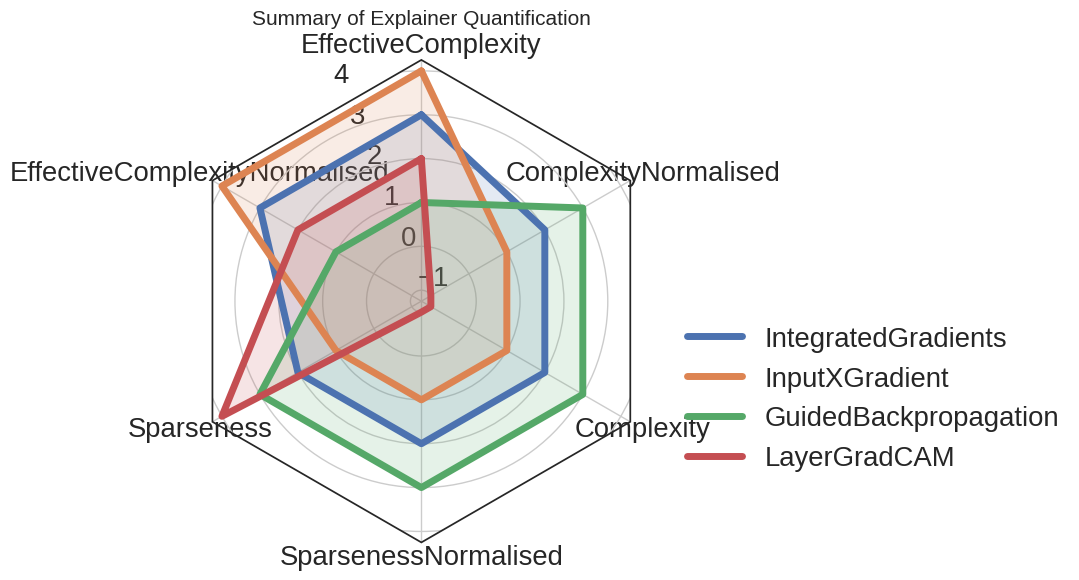

In [17]:
plot_spyder_graph(
    df_normalised_rank=df_normalised_rank,
    xai_methods=xai_methods,
    metric_weight_dict=metric_weight_dict,
)

## More metrics

In [132]:
explainer_wrapper = {
    "InputXGradient": input_x_gradients_explainer,
    "IntegratedGradients": integrated_gradients_explainer,
    "GuidedBackprop": guided_backprop_explainer,
}

# Define XAI methods and metrics.
xai_methods = list(explainer_wrapper.keys())
metrics = {
    "NonSensitivity": quantus.NonSensitivity(
        n_samples=100,    # number of samples to generate
        features_in_step=28, # number of features permuted in each step; the higher number the faster each step is computed
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=False,
        display_progressbar=True,   # important to see progress bar and estimate time of computations
    ),
    "Sparseness": quantus.Sparseness(
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=False,
    ),
    "Complexity": quantus.Complexity(
        abs=True,
        normalise=False,
    ),
    "EffectiveComplexity": quantus.EffectiveComplexity(
        abs=True,
        normalise=False,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=False,
    ),
    "Infidelity": quantus.Infidelity(),
    "FaithfullnessCorrelation": quantus.FaithfulnessCorrelation(),
    "FaithfullnessEstimate": quantus.FaithfulnessEstimate(),
    "PixelFlipping": quantus.PixelFlipping(),
    "RegionPerturbation": quantus.RegionPerturbation(),
    "Selectivity": quantus.Selectivity(),
    "SensitivityN": quantus.SensitivityN(),
    "Sufficiency": quantus.Sufficiency(),
    "AvgSensitivity": quantus.AvgSensitivity(),
    "Consistency": quantus.Consistency(),
    "LocalLipschitzEstimate": quantus.LocalLipschitzEstimate(),
    "MaxSensitivity": quantus.MaxSensitivity(),
    "RelativeInputStability": quantus.RelativeInputStability(),
    "RelativeOutputStability": quantus.RelativeOutputStability(),
    "RelativeRepresentationStability": quantus.RelativeRepresentationStability(),
}

Warnings and information:
 (1) The Non Sensitivity metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', the number of samples to iterate over 'n_samples' and the threshold value function for the feature to be considered having an insignificant contribution to the model.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Nguyen, An-phi, and María Rodríguez Martínez. 'On quantitative aspects of model interpretability.' arXiv preprint arXiv:2007.07584 (2020)..
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.

Warnings and information:
 (1) The Sparseness metric is likely to be sensitive to the choice of normalis

In [133]:
explainer_attributes = compute_metrics_for_explainers(
    x_batch_list=x_batch_list,
    y_batch_list=y_batch_list,
    explainer_wrapper=explainer_wrapper,
    model=model,
    layer=layer,
    device=device,
)

Explainer name: InputXGradient, time: 0.02 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the d

Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the d

Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.04 seconds
Explainer name: GuidedBackprop, time: 0.01 seconds
Explainer name: InputXGradient, time: 0.01 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.02 seconds
Explainer name: InputXGradient, time: 0.01 seconds
Explainer name: IntegratedGradients, time: 0.05 seconds
Explainer name: GuidedBackprop, time: 0.02 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

In [134]:
results = compute_metrics(
    xai_methods=xai_methods,
    x_batch=x_batch,
    y_batch=y_batch,
    explainer_attributes=explainer_attributes,
    metrics=metrics,
)


Evaluating NonSensitivity: 100%|██████████| 44/44 [06:18<00:00,  8.60s/it]
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/helpers/warn.py:263: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


Evaluating NonSensitivity of InputXGradient method, time: 378.34 seconds
Evaluating Sparseness of InputXGradient method, time: 0.0 seconds
Evaluating Complexity of InputXGradient method, time: 0.0 seconds
Evaluating EffectiveComplexity of InputXGradient method, time: 0.0 seconds
Evaluating Infidelity of InputXGradient method, time: 70.39 seconds
Evaluating FaithfullnessCorrelation of InputXGradient method, time: 13.97 seconds
Evaluating FaithfullnessEstimate of InputXGradient method, time: 103.86 seconds
Evaluating PixelFlipping of InputXGradient method, time: 105.08 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/helpers/warn.py:167: UserWarning: The number of non-overlapping patches (11) for this input and attributionis lower than the number of iterations specified for this metric (100).As a result, the number of measurements may vary for each input.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/helpers/warn.py:167: UserWarning: The number of non-overlapping patches (9) for this input and attributionis lower than the number of iterations specified for this metric (100).As a result, the number of measurements may vary for each input.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/helpers/warn.py:167: UserWarning: The number of non-overlapping patches (12) for this input and attributionis lower than the number of iterations specified for this metric (100).As a result, the number of measurements may vary for each input.
  warnings.warn(
/home/user/praca/Aut

Evaluating RegionPerturbation of InputXGradient method, time: 6.31 seconds
Evaluating Selectivity of InputXGradient method, time: 6.27 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning:

Evaluating SensitivityN of InputXGradient method, time: 102.2 seconds
Evaluating Sufficiency of InputXGradient method, time: 0.02 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full 

Evaluating AvgSensitivity of InputXGradient method, time: 14.3 seconds
Evaluating Consistency of InputXGradient method, time: 0.02 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full 

Evaluating LocalLipschitzEstimate of InputXGradient method, time: 14.47 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full 

Evaluating MaxSensitivity of InputXGradient method, time: 14.34 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full 

Evaluating RelativeInputStability of InputXGradient method, time: 19.75 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the d

Evaluating RelativeOutputStability of InputXGradient method, time: 22.6 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full 

Evaluating RelativeRepresentationStability of InputXGradient method, time: 26.38 seconds


Evaluating NonSensitivity: 100%|██████████| 44/44 [06:07<00:00,  8.35s/it]
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/helpers/warn.py:263: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


Evaluating NonSensitivity of IntegratedGradients method, time: 367.51 seconds
Evaluating Sparseness of IntegratedGradients method, time: 0.0 seconds
Evaluating Complexity of IntegratedGradients method, time: 0.0 seconds
Evaluating EffectiveComplexity of IntegratedGradients method, time: 0.0 seconds
Evaluating Infidelity of IntegratedGradients method, time: 69.96 seconds
Evaluating FaithfullnessCorrelation of IntegratedGradients method, time: 13.64 seconds
Evaluating FaithfullnessEstimate of IntegratedGradients method, time: 101.78 seconds
Evaluating PixelFlipping of IntegratedGradients method, time: 99.7 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/helpers/warn.py:167: UserWarning: The number of non-overlapping patches (12) for this input and attributionis lower than the number of iterations specified for this metric (100).As a result, the number of measurements may vary for each input.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/helpers/warn.py:167: UserWarning: The number of non-overlapping patches (10) for this input and attributionis lower than the number of iterations specified for this metric (100).As a result, the number of measurements may vary for each input.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/helpers/warn.py:167: UserWarning: The number of non-overlapping patches (9) for this input and attributionis lower than the number of iterations specified for this metric (100).As a result, the number of measurements may vary for each input.
  warnings.warn(
/home/user/praca/Aut

Evaluating RegionPerturbation of IntegratedGradients method, time: 6.08 seconds
Evaluating Selectivity of IntegratedGradients method, time: 6.02 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Evaluating SensitivityN of IntegratedGradients method, time: 98.12 seconds
Evaluating Sufficiency of IntegratedGradients method, time: 0.02 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: 

Evaluating AvgSensitivity of IntegratedGradients method, time: 141.54 seconds
Evaluating Consistency of IntegratedGradients method, time: 0.02 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: 

Evaluating LocalLipschitzEstimate of IntegratedGradients method, time: 141.74 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: 

Evaluating MaxSensitivity of IntegratedGradients method, time: 141.43 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: 

Evaluating RelativeInputStability of IntegratedGradients method, time: 148.42 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: 

Evaluating RelativeOutputStability of IntegratedGradients method, time: 151.32 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: 

Evaluating RelativeRepresentationStability of IntegratedGradients method, time: 155.22 seconds


Evaluating NonSensitivity: 100%|██████████| 44/44 [06:07<00:00,  8.34s/it]
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/helpers/warn.py:263: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


Evaluating NonSensitivity of GuidedBackprop method, time: 367.14 seconds
Evaluating Sparseness of GuidedBackprop method, time: 0.01 seconds
Evaluating Complexity of GuidedBackprop method, time: 0.01 seconds
Evaluating EffectiveComplexity of GuidedBackprop method, time: 0.0 seconds
Evaluating Infidelity of GuidedBackprop method, time: 68.28 seconds
Evaluating FaithfullnessCorrelation of GuidedBackprop method, time: 13.83 seconds
Evaluating FaithfullnessEstimate of GuidedBackprop method, time: 99.2 seconds
Evaluating PixelFlipping of GuidedBackprop method, time: 103.13 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/helpers/warn.py:167: UserWarning: The number of non-overlapping patches (11) for this input and attributionis lower than the number of iterations specified for this metric (100).As a result, the number of measurements may vary for each input.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/helpers/warn.py:167: UserWarning: The number of non-overlapping patches (10) for this input and attributionis lower than the number of iterations specified for this metric (100).As a result, the number of measurements may vary for each input.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/quantus/helpers/warn.py:167: UserWarning: The number of non-overlapping patches (9) for this input and attributionis lower than the number of iterations specified for this metric (100).As a result, the number of measurements may vary for each input.
  warnings.warn(
/home/user/praca/Aut

Evaluating RegionPerturbation of GuidedBackprop method, time: 6.07 seconds
Evaluating Selectivity of GuidedBackprop method, time: 6.09 seconds
Evaluating SensitivityN of GuidedBackprop method, time: 105.01 seconds
Evaluating Sufficiency of GuidedBackprop method, time: 0.02 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Evaluating AvgSensitivity of GuidedBackprop method, time: 14.3 seconds
Evaluating Consistency of GuidedBackprop method, time: 0.02 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Evaluating LocalLipschitzEstimate of GuidedBackprop method, time: 14.75 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Evaluating MaxSensitivity of GuidedBackprop method, time: 14.49 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Evaluating RelativeInputStability of GuidedBackprop method, time: 19.97 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Evaluating RelativeOutputStability of GuidedBackprop method, time: 22.81 seconds


/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/user/praca/AutoXAI/.venv/lib/python3.9/site-packages/captum/_utils/gradient.py:57: Us

Evaluating RelativeRepresentationStability of GuidedBackprop method, time: 26.03 seconds


In [135]:
df_normalised_rank = calculate_metric_ranks(
    metrics=metrics,
    xai_methods=xai_methods,
    results=results,
    lower_is_better_metric_names=[
        "Sparseness",
    ],
)
df_normalised_rank

{'InputXGradient': {'NonSensitivity': 1.0, 'Sparseness': 0.9175906960421724, 'Complexity': 4.382893454388154, 'EffectiveComplexity': 143.3181818181818, 'Infidelity': 11042.026601248323, 'FaithfullnessCorrelation': 0.17946031404694937, 'FaithfullnessEstimate': 0.45479559168451283, 'PixelFlipping': 4.8016571141446e-05, 'RegionPerturbation': 0.00047190962808276745, 'Selectivity': 5.982705167913078e-05, 'SensitivityN': nan, 'Sufficiency': 0.0, 'AvgSensitivity': 1.050704306587577, 'Consistency': 0.0, 'LocalLipschitzEstimate': 0.920514376343114, 'MaxSensitivity': 1.6295583762905814, 'RelativeInputStability': nan, 'RelativeOutputStability': nan, 'RelativeRepresentationStability': nan}, 'IntegratedGradients': {'NonSensitivity': 1.0, 'Sparseness': 0.9142169779218907, 'Complexity': 4.427955650108137, 'EffectiveComplexity': 143.36363636363637, 'Infidelity': 14449.78045770939, 'FaithfullnessCorrelation': 0.2319768641432708, 'FaithfullnessEstimate': 0.33222136914959527, 'PixelFlipping': 4.320558628

,NonSensitivity,Sparseness,Complexity,EffectiveComplexity,Infidelity,FaithfullnessCorrelation,FaithfullnessEstimate,PixelFlipping,RegionPerturbation,Selectivity,SensitivityN,Sufficiency,AvgSensitivity,Consistency,LocalLipschitzEstimate,MaxSensitivity,RelativeInputStability,RelativeOutputStability,RelativeRepresentationStability
InputXGradient,1.5,1.0,1.0,1.0,1.0,2.0,3.0,2.0,2.0,2.0,-1.0,1.5,3.0,-1.0,2.0,3.0,-1.0,-1.0,-1.0
IntegratedGradients,1.5,2.0,2.0,2.0,2.0,3.0,2.0,1.0,3.0,1.0,-1.0,1.5,2.0,-1.0,1.0,2.0,-1.0,-1.0,-1.0
GuidedBackprop,3.0,3.0,3.0,3.0,3.0,1.0,1.0,3.0,1.0,3.0,1.0,3.0,1.0,-1.0,3.0,1.0,-1.0,-1.0,-1.0


Best explainers based on weighted metric score (higher is better)
	Explainer_name: 'GuidedBackprop', score: 29.0
	Explainer_name: 'InputXGradient', score: 21.0
	Explainer_name: 'IntegratedGradients', score: 21.0


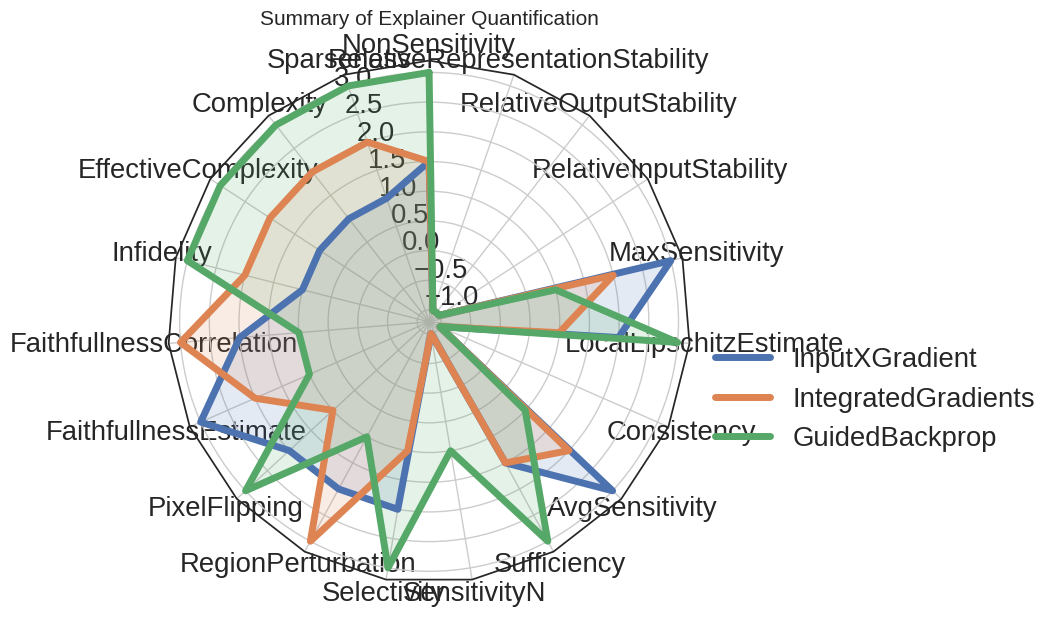

In [136]:
metric_weight_dict = {key: 1.0 for key in metrics.keys()}
best_explainer = get_explainers_score(
    df_normalised_rank=df_normalised_rank,
    metric_weight_dict=metric_weight_dict,
)

print("Best explainers based on weighted metric score (higher is better)")
for explainer in best_explainer:
    print(f"\tExplainer_name: '{explainer[0]}', score: {explainer[1]}")

plot_spyder_graph(
    df_normalised_rank=df_normalised_rank,
    xai_methods=xai_methods,
    metric_weight_dict=metric_weight_dict,
)